# Explore population outbreaks in Fringilla insect data 

Due to high number of missing values, this line of research focusses on the years from 1998 to 2020.

**It's the first time during this research progress that the data is actually in a *tidy* format!**

In [1]:
'''
NOTE:
- it's reasonable to also analyse the climate prior (up to a year or so) 
  to outbreaks
- I still have to decide on a suitable period of time to summarise the daily
  counts
'''

"\nNOTE:\n- it's reasonable to also analyse the climate prior (up to a year or so) \n  to outbreaks\n- I still have to decide on a suitable period of time to summarise the daily\n  counts\n"

In [2]:
# import libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

### DATA IMPORT

In [3]:
pkl_files = ['species.pkl', 'species_long.pkl', 'species_summed.pkl']

# define import function
def import_pickled_data():
    dummy = []
    for file in pkl_files:
        with open('../../data/'+file, 'rb') as f:
            dummy.append(pkl.load(f))
    return dummy

species, species_long, species_summed = import_pickled_data()

### CONVERT INTO "TIDY FORM"

In [4]:
# get data into tidy form!
# i.e., single dataframe with variables as columns and single observations as rows

sheets = ['Vanessa atalanta', 'Vanessa cardui', 'Inachis io', 'Issoria lathonia', 'Aglais urticae',
          'Aporia crataegi', 'Apatura ilia', 'Aphantopus hyperanthus', 'Araschnia levana', 'Nymphalis antiopa',
          'Nymphalis polychloros', 'Nymphalis xanthomelas', 'Papilio machaon', 'Polygonia c-album', 'Pararge aegeria']

all_species = pd.DataFrame()
for s in sheets:
    df = species_summed[s]
    df['species'] = s # add species column
    df = df[['species', 'datetime', 'count', 'Temp', 'Wind', 'Cloud']] # select columns
    all_species = pd.concat([all_species, df]) # put final df together

### DATA PROCESSING

In [5]:
# rename columns
all_species.rename(
    columns={'Temp': 'tmp', 'Wind': 'wind', 'Cloud':'cloud'}, 
    inplace=True
)

# NOTE: remove high tmp values!
all_species['tmp'].values[all_species['tmp'] > 50] = np.nan

# specify time period (1998-2020)
# use datetime attribute "dt" to access the datetime components!
all_species = all_species[all_species['datetime'].dt.year >= 1998]

# and reset index
all_species.reset_index(drop=True, inplace=True)

# add year, month, day column
all_species['year'] = all_species['datetime'].dt.year
all_species['month'] = all_species['datetime'].dt.month
all_species['day'] = all_species['datetime'].dt.day

display(all_species)

,species,datetime,count,tmp,wind,cloud,year,month,day
0,Vanessa atalanta,1998-04-01,NaN,NaN,NaN,NaN,1998,4,1
1,Vanessa atalanta,1998-04-02,NaN,NaN,NaN,NaN,1998,4,2
2,Vanessa atalanta,1998-04-03,NaN,NaN,NaN,NaN,1998,4,3
3,Vanessa atalanta,1998-04-04,NaN,NaN,NaN,NaN,1998,4,4
4,Vanessa atalanta,1998-04-05,NaN,NaN,NaN,NaN,1998,4,5
...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28
74171,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29
74172,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30
74173,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31


## ABUNDANCE INDEX (to classify outbreaks)

To quantify an outbreak, we compute the derivation from the **median** and take the logarithm to adjust for high index values. As the index can be negative, we use the logarithm as follows:

![logarithm](https://i.stack.imgur.com/xnYkb.png)

**Note**: Instead of the natural logarithm, we use the logarithm of base 10.

In [6]:
def mylog(x):
    if x > 0:
        log = np.log10(x)
    elif x < 0:
        log = np.log10(x*-1)*-1
    elif x == 0:
        log = 0
    return log

In [7]:
# sum up counts in each year
outbreaks = all_species.groupby(['species', 'year'], as_index=False)['count'].sum()

# compute total average count (across all years)
avg_count = outbreaks.groupby(['species'])['count'].median()
# https://stackoverflow.com/questions/62490392/how-to-apply-log-on-negative-values-based-upon-some-conditions-in-python

# add average count to df
outbreaks = outbreaks.set_index(['species'])
outbreaks['avg'] = avg_count
outbreaks = outbreaks.reset_index()

# computing outbreak index with zero reflecting the total average count
outbreaks['index'] = outbreaks['count'] - outbreaks['avg']
outbreaks['log index'] = outbreaks['index'].apply(mylog)

display(outbreaks)

,species,year,count,avg,index,log index
0,Aglais urticae,1998,2.0,15.0,-13.0,-1.113943
1,Aglais urticae,1999,1.0,15.0,-14.0,-1.146128
2,Aglais urticae,2000,2.0,15.0,-13.0,-1.113943
3,Aglais urticae,2001,8.0,15.0,-7.0,-0.845098
4,Aglais urticae,2002,77.0,15.0,62.0,1.792392
...,...,...,...,...,...,...
340,Vanessa cardui,2016,39.0,14.0,25.0,1.397940
341,Vanessa cardui,2017,6.0,14.0,-8.0,-0.903090
342,Vanessa cardui,2018,11.0,14.0,-3.0,-0.477121
343,Vanessa cardui,2019,3270.0,14.0,3256.0,3.512684


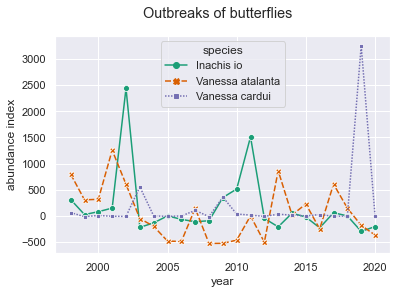

In [30]:
# plotting
data = outbreaks[
    (outbreaks['species'] == 'Vanessa atalanta') | 
    (outbreaks['species'] == 'Vanessa cardui') |
    (outbreaks['species'] == 'Inachis io')
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='year', y='index', 
             hue='species', style='species', markers=True, ax=ax)
ax.set_ylabel('abundance index')
fig.suptitle('Outbreaks of butterflies')
fig.savefig('../figs/kaliningrad/outbreaks_per-year.png', 
            dpi=600, bbox_inches='tight')

### OUTBREAKS BY SEASON

Let's split the outbreaks index into spring (april to june) and summer (july to october) to identify temporal patterns.

In [9]:
def which_season(row):
    if row['month'] < 7:   # define spring as
        val = 'spring'     # april to june, skip
    elif row['month'] > 7: # july, and autumn from
        val = 'autumn'     # august to october
    else:
        val = 'july'
    return val

def outbreaks_per_season(df):
    # add column with spring/summer
    df['season'] = df.apply(which_season, axis=1)
    #df['season'] = np.where(df['month'].isin([4, 5, 6]), 'spring', 'autumn')
    
    # sum up counts per season
    df = df.groupby(['species', 'year', 'season'], as_index=False)['count'].sum()

    # compute average count across all years
    df = df.join(
        df.groupby(['species', 'season'])['count'].median(),
        on=['species', 'season'],
        rsuffix='_avg'
    )
    # computing outbreak index with zero reflecting the total average count
    df['index'] = df['count'] - df['count_avg']
    return df

outbreaks_season = outbreaks_per_season(all_species)

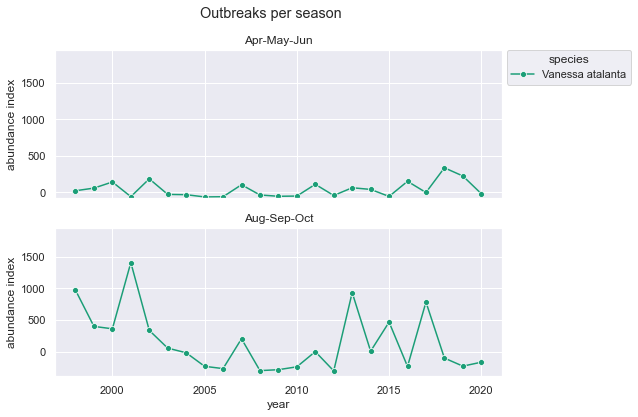

In [47]:
# plotting
data = outbreaks_season[
    (outbreaks_season['species'] == 'Vanessa atalanta') 
    #| (outbreaks_season['species'] == 'Vanessa cardui')
    #| (outbreaks_season['species'] == 'Inachis io')
]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
sns.lineplot(data=data[data.season == 'spring'], x='year', y='index',
             hue='species', marker='o', ax=axs[0], legend=False, label='Vanessa atalanta')
sns.lineplot(data=data[data.season == 'autumn'], x='year', y='index',
             hue='species', marker='o', ax=axs[1], legend=False)
axs[0].set_title('Apr-May-Jun')
axs[1].set_title('Aug-Sep-Oct')
for i in range(len(axs)):
    axs[i].set_ylabel('abundance index')
    axs[i].set_ylim(top=1950)
fig.legend(title='species', loc='center left', bbox_to_anchor=(0.9, 0.84))
fig.suptitle('Outbreaks per season')
fig.savefig('../figs/kaliningrad/outbreaks_per-season.png', 
           dpi=600, bbox_inches='tight')

### MEAN SEASONAL PATTERN (to temporally locate outbreaks)

`count_sum` = accumulated count in specific time interval </br>
`all_species_mean` = dataframe with mean count per day for all years

In [11]:
# computing accumulated count for fixed number of observations (i.e., days)
moving_window_size = 21

accumulated_counts = all_species.groupby(['species', 'year']).rolling(
    window=moving_window_size,
    min_periods=1,
    center=True,
)['count'].sum().sort_index(level=2) # somehow, the order of count values is
                                     # changed, hence, use index to re-order 
                                     # the Pandas series!

all_species['count_sum'] = accumulated_counts.values # Pandas series has index,
                                                     # hence, just use values!

# save data in tidy format, might be useful later...
all_species.to_csv('all_species_tidy.csv', index=False)

all_species

,species,datetime,count,tmp,wind,cloud,year,month,day,season,count_sum
0,Vanessa atalanta,1998-04-01,NaN,NaN,NaN,NaN,1998,4,1,spring,0.0
1,Vanessa atalanta,1998-04-02,NaN,NaN,NaN,NaN,1998,4,2,spring,0.0
2,Vanessa atalanta,1998-04-03,NaN,NaN,NaN,NaN,1998,4,3,spring,0.0
3,Vanessa atalanta,1998-04-04,NaN,NaN,NaN,NaN,1998,4,4,spring,0.0
4,Vanessa atalanta,1998-04-05,NaN,NaN,NaN,NaN,1998,4,5,spring,0.0
...,...,...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28,autumn,0.0
74171,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29,autumn,0.0
74172,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30,autumn,0.0
74173,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31,autumn,0.0


In [12]:
# computing mean count per day (i.e., per fixed number of observations)
all_species_mean = all_species.groupby(['species', 'month', 'day'],
                   as_index=False)['count_sum'].mean()

# the quick & dirty way to get a datetime object column, which is needed for
# plotting soon
all_species_mean['year'] = 1900
all_species_mean['datetime'] = pd.to_datetime(all_species_mean[['year', 'month', 'day']])
all_species_mean = all_species_mean.drop('year', axis=1)
all_species_mean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   species    3225 non-null   object        
 1   month      3225 non-null   int64         
 2   day        3225 non-null   int64         
 3   count_sum  3225 non-null   float64       
 4   datetime   3225 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 126.1+ KB


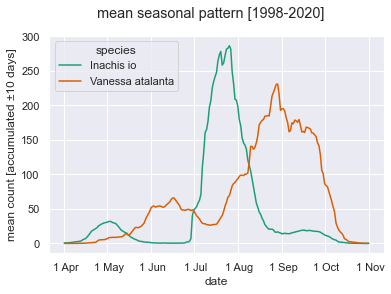

In [32]:
# plotting
data = all_species_mean[
    (all_species_mean['species'] == 'Vanessa atalanta') 
    #| (all_species_mean['species'] == 'Vanessa cardui')
    | (all_species_mean['species'] == 'Inachis io')
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count_sum', hue='species', ax=ax)

# Define the date format -----------------
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
#fig.autofmt_xdate()
# ----------------------------------------

ax.set_ylabel(f'mean count [accumulated ±{int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('mean seasonal pattern [1998-2020]')
fig.savefig('../figs/kaliningrad/outbreaks_mean-seasonal-pattern.png', 
            dpi=600, bbox_inches='tight')

### 2019 vanessa cardui outbreak 

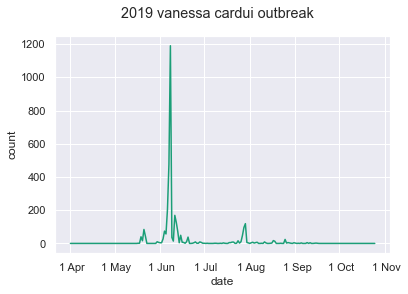

In [14]:
data = all_species[
    (all_species['species'] == 'Vanessa cardui') &
    (all_species['year'] == 2019)
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count', ax=ax)

# Define the date format -----------------
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
# ----------------------------------------

#ax.set_ylabel(f'count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('2019 vanessa cardui outbreak')
fig.savefig('../figs/kaliningrad/outbreaks_v-cardui_2019.png', 
            dpi=600, bbox_inches='tight')

### 2002 inachis io outbreak

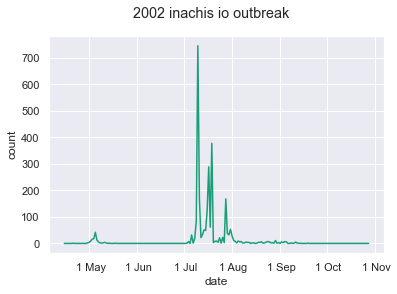

In [15]:
data = all_species[
    (all_species['species'] == 'Inachis io') &
    (all_species['year'] == 2002)
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count', ax=ax)

# Define the date format -----------------
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
# ----------------------------------------

#ax.set_ylabel(f'count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('2002 inachis io outbreak')
fig.savefig('../figs/kaliningrad/outbreaks_i-io_2002.png', 
            dpi=600, bbox_inches='tight')

### TEMPERATURE COMPARISON

The [ECA dataset](https://www.ecad.eu/dailydata/index.php) contains series of daily observations at meteorological stations throughout Europe and the Mediterranean.

In [16]:
# read daily temperature data from weather stations and merge into single dataframe
def read_eca_stations(files, names):

    df_final = pd.DataFrame()
    
    for i, file in enumerate(files):
        eca = pd.read_csv( # import txt file                            
            filepath_or_buffer=f'../../data/ECA&D/{file}.txt',
            skiprows=20,
            parse_dates=[2],
            dtype={'TX': np.float64},
            na_values=-9999
        )    
        eca.columns = eca.columns.str.strip()
        eca['TX'] = eca['TX'] / 10 # temperature is stored in °C * 10
        eca = (eca.set_index('DATE')
                  .drop(columns=['STAID', 'SOUID', 'Q_TX'])
                  .rename(columns={'TX': names[i]}))
        df_final = pd.concat([df_final, eca], axis='columns')
    return df_final

df_weather_stations = read_eca_stations(
    ['TX_STAID000077', 'TX_STAID000201', 'TX_STAID000199', 'TX_STAID001012'],
    ['Kaliningrad',    'Klaipeda',       'Liepaja',        'Nida']
)
df_weather_stations

,Kaliningrad,Klaipeda,Liepaja,Nida
DATE,,,,
1881-01-01,NaN,NaN,0.0,NaN
1881-01-02,NaN,NaN,0.0,NaN
1881-01-03,NaN,NaN,0.0,NaN
1881-01-04,NaN,NaN,0.0,NaN
1881-01-05,NaN,NaN,0.0,NaN
...,...,...,...,...
2022-03-27,NaN,NaN,4.6,NaN
2022-03-28,NaN,NaN,7.2,NaN
2022-03-29,NaN,NaN,4.7,NaN


In [17]:
temp_records = (['Kaliningrad', 'Klaipeda', 'Liepaja'] # initial weather stations
                + ['Fringilla'] # site of insect count
                + ['Nida']) # weather stations that were added later-on
 
# join with fringilla insect data
tmp_comparison = all_species.join(
    df_weather_stations,
    on='datetime',
    how='inner'
).reset_index(drop=True).rename(
    columns={'tmp': 'Fringilla'}
)

# convert to long format and remove non-temperature data
tmp_comparison = tmp_comparison.melt(
    id_vars=['datetime', 'year', 'month', 'day'],
    value_vars=temp_records,
    var_name='data_origin',
    value_name='tmp'
).drop_duplicates().reset_index(drop=True)
tmp_comparison

,datetime,year,month,day,data_origin,tmp
0,1998-04-01,1998,4,1,Kaliningrad,11.3
1,1998-04-02,1998,4,2,Kaliningrad,4.8
2,1998-04-03,1998,4,3,Kaliningrad,7.0
3,1998-04-04,1998,4,4,Kaliningrad,8.0
4,1998-04-05,1998,4,5,Kaliningrad,14.6
...,...,...,...,...,...,...
24720,2020-10-28,2020,10,28,Nida,NaN
24721,2020-10-29,2020,10,29,Nida,NaN
24722,2020-10-30,2020,10,30,Nida,NaN
24723,2020-10-31,2020,10,31,Nida,NaN


In [18]:
# get hex color codes of Dark2 matplotlib colormap
from matplotlib import cm, colors

cmap = cm.get_cmap('Dark2', 8)

hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

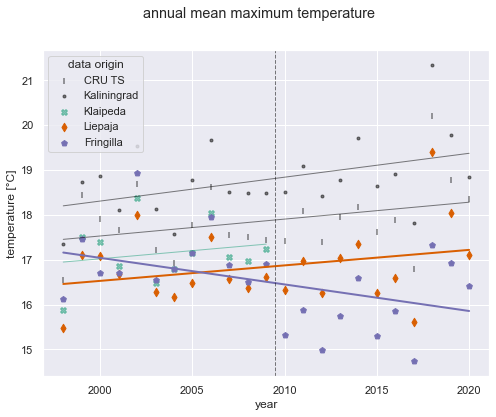

In [19]:
# get cru ts tmp data
%store -r cru_tmp_yr

# compute annual mean MAX temperature
data = tmp_comparison.groupby(['year', 'data_origin'], as_index=False)['tmp'].mean()

# plotting...
fig, ax = plt.subplots(figsize=(8, 6))
m = ['.', 'X', 'd', 'p']
c = ['k', hex[0], hex[1], hex[2]]
alpha = [0.5, 0.5, 1, 1]
lw = [1, 1, 2, 2]

# cru ts
sns.regplot(x=np.arange(1998,2021), y=cru_tmp_yr,
            line_kws={'linewidth': 1, 'alpha': 0.5},
            scatter_kws={'alpha': 0.5},
            label='CRU TS',
            ax=ax, ci=None, color='k', marker='|')

# weather stations & fringilla
for i, loc in enumerate(temp_records[:-1]): # excluding Nida weather station
    sns.regplot(
        data=data[data['data_origin'] == loc],
        x='year', y='tmp',
        line_kws={'linewidth': lw[i], 'alpha': alpha[i]},
        scatter_kws={'alpha': alpha[i]},
        label=loc, color=c[i],
        ax=ax, ci=None, marker=m[i])

ax.legend(title='data origin', loc='upper left')
ax.set_ylabel('temperature [°C]')
ax.axvline(x=2009.5, ls='--', lw=1, c='k', alpha=0.5)
fig.suptitle('annual mean maximum temperature')
fig.savefig('../figs/kaliningrad/temperature-comparison.png', 
            dpi=600, bbox_inches='tight')

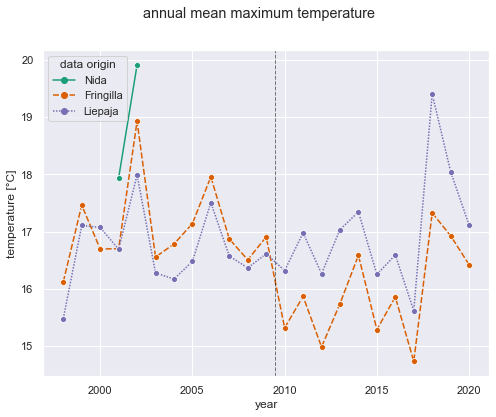

In [20]:
# compare tmp records of Fringilla and Nida (closest station, but isn't included
# in CRU TS and thus wasn't initially considered)

sns_order = ['Nida', 'Fringilla', 'Liepaja']

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(
    data=data[data.data_origin.str.contains('Fringilla|Nida|Liepaja')],
    x='year', y='tmp', hue='data_origin', style='data_origin',
    markers = ['o']*3, ax=ax,
    hue_order = sns_order, style_order = sns_order,
)
ax.legend(title='data origin', loc='upper left')
ax.set_ylabel('temperature [°C]')
ax.axvline(x=2009.5, ls='--', lw=1, c='k', alpha=0.5)
fig.suptitle('annual mean maximum temperature')
fig.savefig('../figs/kaliningrad/temperature-comparison-nida.png', 
            dpi=600, bbox_inches='tight')

In [21]:
# compute difference of Fringilla and Liepaja
daily_comp = tmp_comparison.pivot(
    index=['datetime', 'year'], 
    columns='data_origin', values='tmp'
).drop(
    columns=['Kaliningrad', 'Klaipeda']
).reset_index()
daily_comp.columns.name = None
daily_comp['diff'] = daily_comp['Fringilla'] - daily_comp['Liepaja']
daily_comp

,datetime,year,Fringilla,Liepaja,Nida,diff
0,1998-04-01,1998,NaN,4.9,NaN,NaN
1,1998-04-02,1998,NaN,4.2,NaN,NaN
2,1998-04-03,1998,NaN,4.7,NaN,NaN
3,1998-04-04,1998,NaN,2.3,NaN,NaN
4,1998-04-05,1998,NaN,6.3,NaN,NaN
...,...,...,...,...,...,...
4940,2020-10-28,2020,NaN,12.2,NaN,NaN
4941,2020-10-29,2020,NaN,13.0,NaN,NaN
4942,2020-10-30,2020,NaN,11.1,NaN,NaN
4943,2020-10-31,2020,NaN,8.6,NaN,NaN


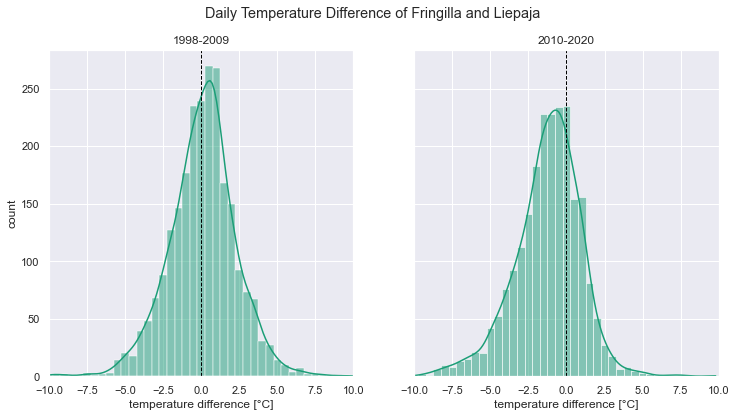

In [22]:
def plot_histo(ax, interval):
    sns.histplot(
        data=daily_comp[daily_comp['year'].isin(interval)], 
        x='diff', stat='count', binwidth=0.5, binrange=(-10.25, 10.25),
        kde=True, ax=ax
    )
    ax.set_xlim(-10,10)
    ax.set_xlabel('temperature difference [°C]')
    ax.set_ylabel('count')
    ax.set_title(f'{interval[0]}-{interval[-1]}')
    ax.axvline(x=0, c='k', ls='--', lw=1)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6))

plot_histo(axs[0], np.arange(1998,2010))
plot_histo(axs[1], np.arange(2010,2020+1))

fig.suptitle('Daily Temperature Difference of Fringilla and Liepaja')

fig.savefig('../figs/kaliningrad/temperature-difference.png', 
            dpi=600, bbox_inches='tight')

Text(0.5, 0.98, 'Daily Temperature Difference of Fringilla and Liepaja')

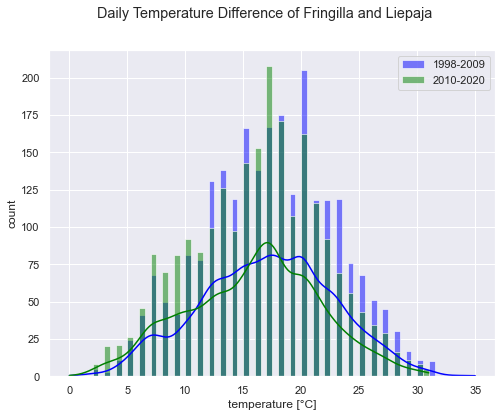

In [23]:
def plot_histo(ax, interval, c):
    sns.histplot(
        data=daily_comp[daily_comp['year'].isin(interval)], 
        x='Fringilla', stat='count', binwidth=0.5, color=c,
        kde=True, ax=ax, label=f'{interval[0]}-{interval[-1]}',
        alpha=0.5, kde_kws={'bw_adjust': 0.75}
    )
    ax.set_xlabel('temperature [°C]')
    ax.set_ylabel('count')

fig, ax = plt.subplots(figsize=(8,6))

plot_histo(ax, np.arange(1998,2010), 'blue')
plot_histo(ax, np.arange(2010,2020+1), 'green')

ax.legend()
fig.suptitle('Daily Temperature Difference of Fringilla and Liepaja')

### DIVING INTO DISTRIBUTION OF TEMPERATURE RECORDINGS

i.e., random plots...

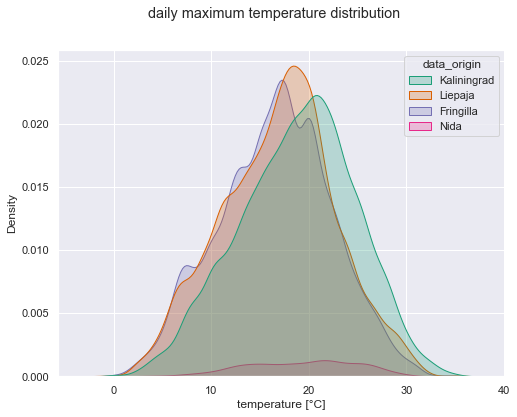

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(
    data=tmp_comparison[(tmp_comparison['data_origin'] != 'Klaipeda')],
    x='tmp',
    hue='data_origin',
    fill=True,
    bw_adjust=0.75,
    ax=ax,
)
ax.set_xlabel('temperature [°C]')
fig.suptitle('daily maximum temperature distribution')
fig.savefig('../figs/kaliningrad/temperature-kde.png', 
            dpi=600, bbox_inches='tight')

<AxesSubplot:xlabel='tmp', ylabel='Density'>

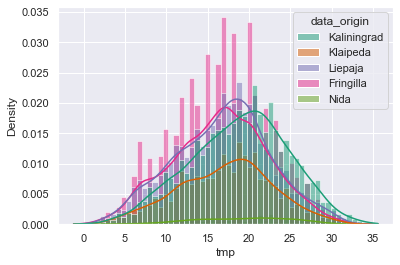

In [25]:
sns.histplot(
    data=tmp_comparison, x='tmp', hue='data_origin', stat='density', kde=True
)

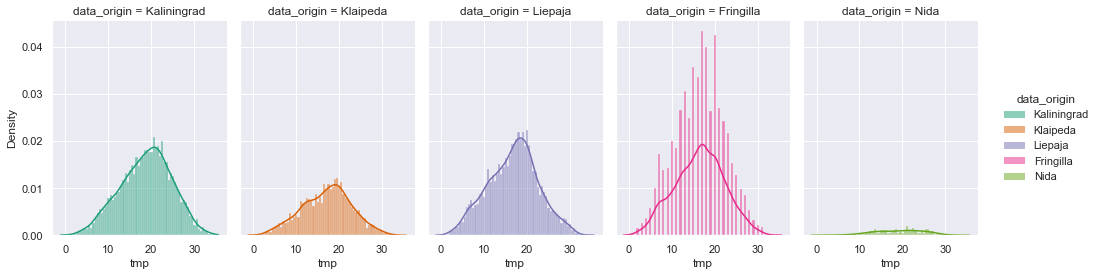

In [26]:
sns.displot(
    data=tmp_comparison, x='tmp', hue='data_origin', col='data_origin',
    kind='hist', height=4, aspect=.7, kde=True, binwidth=0.5, stat='density'
)

In [27]:
tmp_comparison

,datetime,year,month,day,data_origin,tmp
0,1998-04-01,1998,4,1,Kaliningrad,11.3
1,1998-04-02,1998,4,2,Kaliningrad,4.8
2,1998-04-03,1998,4,3,Kaliningrad,7.0
3,1998-04-04,1998,4,4,Kaliningrad,8.0
4,1998-04-05,1998,4,5,Kaliningrad,14.6
...,...,...,...,...,...,...
24720,2020-10-28,2020,10,28,Nida,NaN
24721,2020-10-29,2020,10,29,Nida,NaN
24722,2020-10-30,2020,10,30,Nida,NaN
24723,2020-10-31,2020,10,31,Nida,NaN


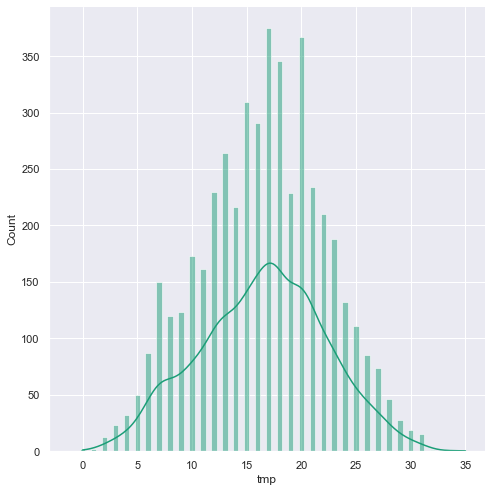

In [28]:
sns.displot(
    data=tmp_comparison[tmp_comparison.data_origin == 'Fringilla'], 
    x='tmp', height=7, kind='hist', kde=True, binwidth=0.5, binrange=(-1.25, 32.25)
)